In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My\ Drive/CPM_Pytorch

/content/drive/My Drive/CPM_Pytorch


In [4]:
import matplotlib
matplotlib.use('TKAgg')

from data_loader.dataLoader import CarDataset as Mydata
from model.cpm import CPM
from src.util import heatmap_image,save_images,PCK

import os
import torch
import torch.optim as optim
import torch.nn as nn
import configparser

from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import transforms
from PIL import Image, ImageDraw

In [5]:
#Hyperparams
config = configparser.ConfigParser()
config.read('conf_online.text')

train_data_dir = config.get('data', 'train_data_dir')
model_save_dir=config.get('data', 'model_save_dir')
annotation_save_dir=config.get('data', 'annotation_save_dir')

save_dir = config.get('data', 'save_dir')

learning_rate = config.getfloat('training', 'learning_rate')
batch_size = config.getint('training', 'batch_size')
epochs = config.getint('training', 'epochs')
begin_epoch = config.getint('training', 'begin_epoch')
n_keypoints=config.getint('training', 'n_keypoints')  



In [6]:
cuda = torch.cuda.is_available()
 

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [7]:
# *********************** Build dataset ***********************
train_data = Mydata(data_dir=train_data_dir,n_keypoints=4)


print ('Train dataset total number of images sequence is ----' + str(len(train_data)))

# Data Loader
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Train dataset total number of images sequence is ----717


In [8]:
batch_size

16

In [9]:
net = CPM(out_c=n_keypoints)

device_ids = [0]  
if cuda:
    net = net.cuda(device_ids[0])
    net = nn.DataParallel(net, device_ids=device_ids)
print(model_save_dir)
if begin_epoch > 0:
    save_path =model_save_dir+'model_epoch' + str(begin_epoch) + '.pth'
    state_dict = torch.load(save_path)
    net.load_state_dict(state_dict)

models/


In [10]:
def train():
    # *********************** initialize optimizer ***********************
    optimizer = optim.Adam(params=net.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    criterion = nn.MSELoss(size_average=True)                       # loss function MSE average

    net.train()
    for epoch in range(begin_epoch, epochs + 1):
        print ('epoch....................' + str(epoch))
        
        for step, (image, label_map, center_map, imgs) in enumerate(train_dataset):
            
            image = Variable(image.cuda() if cuda else image)                   # 4D Tensor
            # Batch_size  *  3  *  width(368)  *  height(368)

            # 4D Tensor to 5D Tensor
            label_map = torch.stack([label_map]*6, dim=1)
            # Batch_size  *  21 *   45  *  45
            # Batch_size  *   6 *   21  *  45  *  45
            label_map = Variable(label_map.cuda() if cuda else label_map)

            center_map = Variable(center_map.cuda() if cuda else center_map)    # 4D Tensor
            # Batch_size  *  width(368) * height(368)

            optimizer.zero_grad()
            pred_6 = net(image, center_map)  # 5D tensor:  batch size * stages * 21 * 45 * 45 #This is huge

            # ******************** calculate loss of each joints ********************
            loss = criterion(pred_6, label_map)

            # backward
            loss.backward()
            loss=loss.detach()
            #import ipdb
            #ipdb.set_trace()
            
            optimizer.step() #Not using SGD
            #gc.collect()

            if step % 10 == 0:
                print ('--step .....' + str(step))
                print ('--loss ',loss.item()*10000)
                gb_factor=10**9
                print('--gpu memory=',torch.cuda.memory_allocated()/gb_factor)

            #if step % 40 == 0:
              #torch.save(net.state_dict(), os.path.join(save_dir, 'model_epoch{:d}.pth'.format(epoch)))
            #    save_images(label_map[:, 5, :, :, :], pred_6[:, 5, :, :, :], step, epoch, imgs)

        if epoch % 5 == 0:
            torch.save(net.state_dict(), os.path.join(save_dir, 'model_epoch{:d}.pth'.format(epoch)))
        
            #Delete tensors from memory
            #del image,label_map,center_map,pred_6

    print ('train done!')

In [11]:
train()

epoch....................0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


--step .....0
--loss  37.91051683947444
--gpu memory= 0.535165952
--step .....10
--loss  24.916399270296097
--gpu memory= 0.535814144
--step .....20
--loss  16.990815056487918
--gpu memory= 0.535814144
--step .....30
--loss  16.024227952584624
--gpu memory= 0.535814144
--step .....40
--loss  15.853724908083677
--gpu memory= 0.535814144
epoch....................1
--step .....0
--loss  15.663322992622852
--gpu memory= 0.53568512
--step .....10
--loss  15.64931240864098
--gpu memory= 0.535237632
--step .....20
--loss  15.493410173803568
--gpu memory= 0.535237632
--step .....30
--loss  15.158574096858501
--gpu memory= 0.535237632
--step .....40
--loss  14.998206170275807
--gpu memory= 0.535237632
epoch....................2
--step .....0
--loss  14.895960921421647
--gpu memory= 0.53568512
--step .....10
--loss  15.021756989881396
--gpu memory= 0.535237632
--step .....20
--loss  14.81038169004023
--gpu memory= 0.535237632
--step .....30
--loss  14.51556570827961
--gpu memory= 0.535237632
--s

In [12]:
def get_locations(pred_6):
  locations=[]
  label_locations=[]
  for keypoint_map in pred_6:
    
    flat_tensor=keypoint_map.view(1,-1)
    val=torch.argmax(flat_tensor)
    locations.append((val//45*(368//45),(val%45)*(368//45)))
  return locations  


In [13]:
def generate_output_image(output,locations):
  
  output_image=transforms.ToPILImage()(output.cpu()).resize((368,368))
  draw = ImageDraw.Draw(output_image)
  for x,y in locations:
    draw.ellipse((y, x, y+5, x+5), fill = 'blue', outline ='blue')
  output_image.putalpha(150)
  return output_image

#output_image=generate_output_image(output.clone(),locations)
#output_image

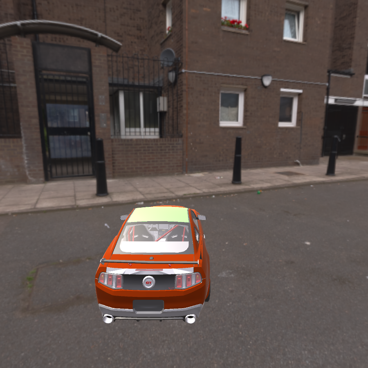

In [14]:
image,labels,center_map,img_dor=train_data[0]
transforms.ToPILImage()(image).resize((368,368))

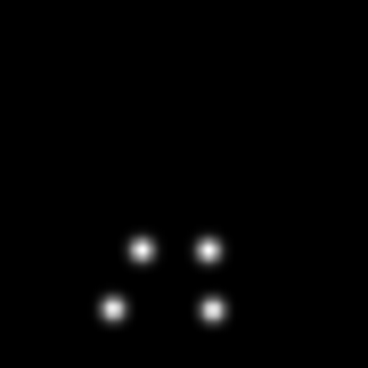

In [18]:
cum_labels=torch.sum(labels,axis=0)
transforms.ToPILImage()(cum_labels).resize((368,368))

In [17]:
label_locations=get_locations(labels)
label_background=img.copy()
label_output=generate_output_image(output.clone(),label_locations)
background.paste(label_output,(0,0),label_output)
background

NameError: ignored

In [19]:
#Prediction
i=0
for image,labels,center_map,img_str in train_data:
  pred_6=net(torch.unsqueeze(image,dim=0),torch.unsqueeze(center_map,dim=0))[0][-1] #Final stage output
  output=pred_6.clone().detach()*0
  pil_image=transforms.ToPILImage()(image)
  background=pil_image

  output_image=generate_output_image(output,get_locations(pred_6))
  background.paste(output_image,(0,0),output_image)
  background.save(annotation_save_dir+'Image'+str(i)+'.PNG')
  i+=1
  #import ipdb
  #ipdb.set_trace()
  print("Saving Image ",i)

Saving Image  1
Saving Image  2
Saving Image  3
Saving Image  4
Saving Image  5
Saving Image  6
Saving Image  7
Saving Image  8
Saving Image  9
Saving Image  10
Saving Image  11
Saving Image  12
Saving Image  13
Saving Image  14
Saving Image  15
Saving Image  16
Saving Image  17
Saving Image  18
Saving Image  19
Saving Image  20
Saving Image  21
Saving Image  22
Saving Image  23
Saving Image  24
Saving Image  25
Saving Image  26
Saving Image  27
Saving Image  28
Saving Image  29
Saving Image  30
Saving Image  31
Saving Image  32
Saving Image  33
Saving Image  34
Saving Image  35
Saving Image  36
Saving Image  37
Saving Image  38
Saving Image  39
Saving Image  40
Saving Image  41
Saving Image  42
Saving Image  43
Saving Image  44
Saving Image  45
Saving Image  46
Saving Image  47
Saving Image  48
Saving Image  49
Saving Image  50
Saving Image  51
Saving Image  52
Saving Image  53
Saving Image  54
Saving Image  55
Saving Image  56
Saving Image  57
Saving Image  58
Saving Image  59
Saving

In [ ]:
!pip install ipdb